<a href="https://colab.research.google.com/github/jermwatt/morphi_lab/blob/collab_demos/scratch_notebooks/2_video_pipeline_unoptimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.  Setup

In [2]:
# install reqiuredlibraries 
!pip install "ultralytics==8.0.111" "transformers==4.29.2" "timm==0.9.2" "diffusers==0.16.1" "safetensors==0.3.1"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# imports
from ultralytics import YOLO
import cv2
from tqdm.notebook import tqdm 
import torch
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import os
parent_dir = os.getcwd()

In [ ]:
# pull yolo model to this macine
!curl -sSL -o /content/YOLOv8s-seg.pt https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8s-seg.pt

In [10]:
# download diffusion models
diffusion_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
diffusion_pipe.to("cuda")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.16.1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

# 1.  Segmenter

## 1.0. Functions

In [8]:
class Segmenter:
    def __init__(self, conf=0.5):
        self.conf = conf
        self.model = YOLO(parent_dir + '/YOLOv8s-seg.pt')
        self.img = None
        self.img_height = None
        self.img_width = None
        self.xmin = None
        self.ymin = None
        self.xmax = None
        self.ymax = None
        self.seg = None
        self.segmentation_result = None
        self.detection_window_path = parent_dir + '/temp/temp.png'

    def reset(self):
        self.img = None
        self.xmin = None
        self.ymin = None
        self.xmax = None
        self.ymax = None
        self.seg = None
        self.width = None
        self.height = None
        self.segmentation_result = None

    def read_img_path(self, img_path):
        self.reset()
        self.img = cv2.imread(img_path)
        h, w, _ = self.img.shape
        self.height = h
        self.width = w

    def read_img(self, img):
        self.reset()
        self.img = img
        h, w, _ = self.img.shape
        self.height = h
        self.width = w

    def segment(self):
        self.segmentation_result = self.model.predict(source=self.img,
                                                      classes=[39, 41, 67],
                                                      conf=self.conf,
                                                      show_labels=False,
                                                      boxes=False,
                                                      verbose=False,
                                                      half=True,
                                                      max_det=1)

        # class names
        self.class_names = self.model.names

        # random colors for plotting
        # self.colors = [[random.randint(0, 255) for _ in range(3)] for _ in self.class_names]
        self.colors = [[100,0,100] for _ in self.class_names]

        # extract segmentation result
        h, w, _ = self.img.shape
        boxes = self.segmentation_result[0].boxes
        masks = self.segmentation_result[0].masks

        if masks is not None:
            masks = masks.data.cpu()
            for seg, box in zip(masks.data.cpu().numpy(), boxes):
                seg = cv2.resize(seg, (w, h)).astype(np.uint8)

                self.xmin = int(box.data[0][0])
                self.ymin = int(box.data[0][1])
                self.xmax = int(box.data[0][2])
                self.ymax = int(box.data[0][3])
                self.seg = seg

                self.detection_window = self.img[self.ymin:self.ymax,
                                                 self.xmin:self.xmax]

                break

    def save_segment(self):
        cv2.imwrite(self.detection_window_path, self.detection_window)

    @staticmethod
    def overlay(image, mask, color, alpha, resize=None):
        colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
        colored_mask = np.moveaxis(colored_mask, 0, -1)
        masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
        image_overlay = masked.filled()

        if resize is not None:
            image = cv2.resize(image.transpose(1, 2, 0), resize)
            image_overlay = cv2.resize(image_overlay.transpose(1, 2, 0), resize)

        image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)

        return image_combined

    @staticmethod
    def plot_one_box(x, img, color=None, label=None, line_thickness=3):
        # Plots one bounding box on image img
        tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
        color = color or [random.randint(0, 255) for _ in range(3)]
        c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
        cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
        if label:
            tf = max(tl - 1, 1)  # font thickness
            t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
            c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
            cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
            cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

    def project_segmentations(self, show_overlay=True, show_boxes=False, show_result=False):
        # unpack segmentation results
        boxes = self.segmentation_result[0].boxes
        masks = self.segmentation_result[0].masks

        # loop over masks and plot
        if masks is not None:
            masks = masks.data.cpu()
            for seg, box in zip(masks.data.cpu().numpy(), boxes):
                seg = cv2.resize(seg, (self.width, self.height)).astype(np.uint8)

                if show_overlay:
                    self.img = self.overlay(self.img, seg, self.colors[int(box.cls)], 0.4)

                xmin = int(box.data[0][0])
                ymin = int(box.data[0][1])
                xmax = int(box.data[0][2])
                ymax = int(box.data[0][3])

                if show_boxes:
                    self.plot_one_box([xmin, ymin, xmax, ymax],
                                      self.img,
                                      self.colors[int(box.cls)],
                                      f'{self.class_names[int(box.cls)]} {float(box.conf):.3}')

    def show_result(self):
        # image_rgb = cv2.imshow('img', img)
        image_rgb = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)

        plt.imshow(image_rgb)
        plt.axis('off')  # optional: disable the axis
        plt.show()

## 1.1.  Image test

In [ ]:
# pull image
!curl -sSL -o /content/test_img.png https://github.com/jermwatt/morphi_lab/blob/collab_demos/test_data/test_input/test_img.png?raw=true 

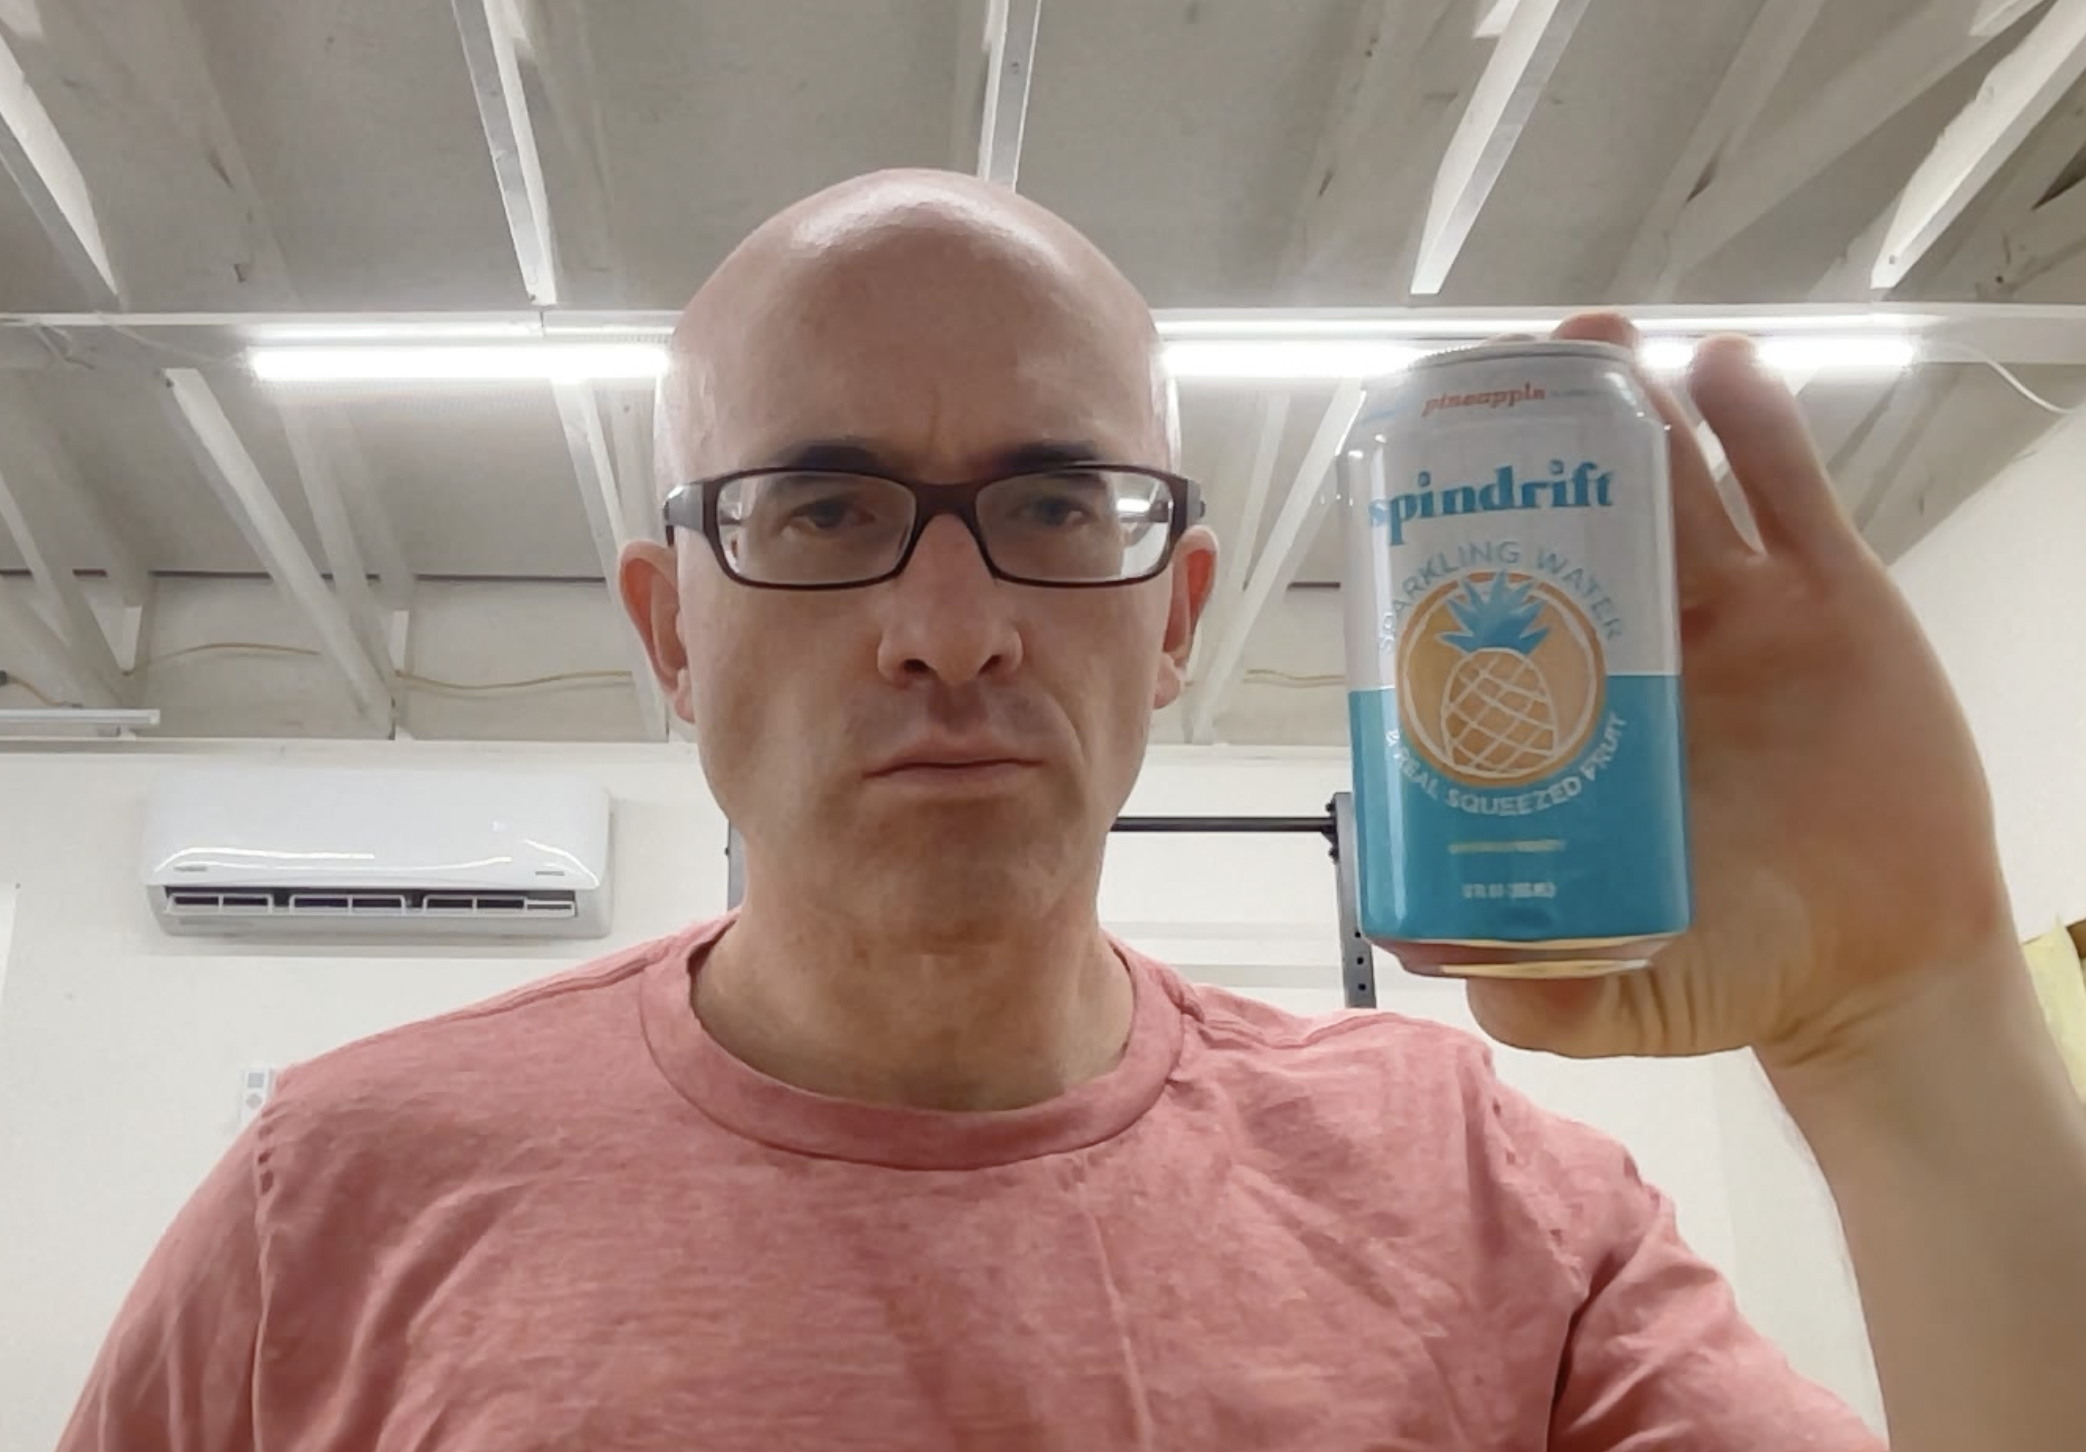

In [ ]:
# path to image 
img_path = "/content/test_img.png"

# load in image
img = cv2.imread(img_path)

# show img
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
img = img.convert('RGB')
img

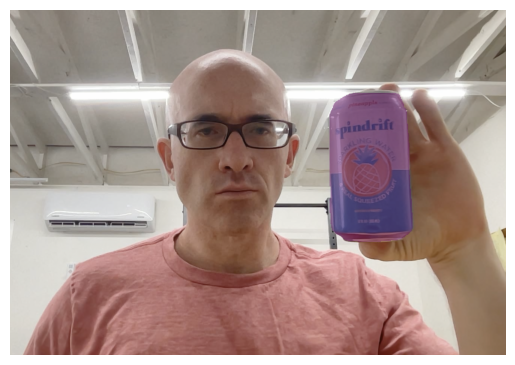

In [ ]:
# segment frame
segmenter = Segmenter(conf=0.15)
segmenter.read_img_path(img_path)
segmenter.segment()
segmenter.project_segmentations()
segmenter.show_result()

## 1.2. Video test

In [ ]:
# pull video
!curl -sSL -o /content/test_video.avi https://github.com/jermwatt/morphi_lab/blob/collab_demos/test_data/test_input/1.avi?raw=true 

In [5]:


def segment_video(input_path, output_path):
    # read in video
    cap = cv2.VideoCapture(input_path)

    # get total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # setup tqdm
    pbar = tqdm(total=total_frames)

    # get frame width and height from img
    success, img = cap.read()

    # get frame width and height from img
    frame_width = img.shape[1]
    frame_height = img.shape[0]

    # define codec and create VideoWriter object
    size = (frame_width, frame_height)
    result = cv2.VideoWriter(output_path,
                             cv2.VideoWriter_fourcc(*'MJPG'),
                             30, size)

    # loop through video
    while success is not None:
        try:
            # segment frame
            segmenter = Segmenter(conf=0.15)
            segmenter.read_img(img)
            segmenter.segment()
            segmenter.project_segmentations()

            # write frame
            result.write(segmenter.img)
        except Exception as e:
            print(e, flush=True)
            break

        # read in next frame
        ret, img = cap.read()

        # update tqdm
        pbar.update(1)

    # release video
    cap.release()
    result.release()
    cv2.destroyAllWindows()

    # close tqdm
    pbar.close()

In [6]:
input_path = '/content/test_video.avi'
output_path = '/content/test_video_segmented.avi'
segment_video(input_path, output_path)

  0%|          | 0/118 [00:00<?, ?it/s]

'NoneType' object has no attribute 'shape'


# 2.  Diffuse objects

## 2.0.  Functions

In [29]:
# plot img and mask 
import matplotlib.pyplot as plt

def plot_frame(img_path):
    av = AV(img_path)
    av.show_result()
    
def plot_frame_and_mask(img, mask):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[1].imshow(mask)
    plt.show()
    
    
# transform frame
def transform_frame(frame,
                     prompt="coca cola can, high resolution, logo visible, red and white colors",
                     conf=0.15):
    # detect and segment
    segmenter = Segmenter(conf=conf)
    segmenter.read_img(frame)
    segmenter.segment()
    segmenter.project_segmentations()
    segmented_frame = segmenter.img

    # convert mask to PIL image
    mask = segmenter.segmentation_result[0].masks.data[0].cpu().numpy()
    mask = mask.astype(np.uint8)*255
    mask = np.stack((mask,)*3, axis=-1)
    mask = Image.fromarray(mask)
    mask = mask.convert('RGB')
    mask = mask.resize((512, 512)) 

    # resize segmenter.img to 448x640
    frame = cv2.resize(segmenter.img, (640, 448))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = Image.fromarray(frame)
    frame = frame.convert('RGB')
    frame = frame.resize((512, 512))

    # difuse mask
    difused_frame = diffusion_pipe(prompt=prompt, image=frame, mask_image=mask).images[0]
    
    # resize frames to 640x448
    segmented_frame = cv2.cvtColor(segmented_frame, cv2.COLOR_BGR2RGB)
    segmented_frame = Image.fromarray(segmented_frame)
    segmented_frame = segmented_frame.resize((640, 448))
    difused_frame = difused_frame.resize((640, 448))
    return segmented_frame, difused_frame

## 2.1.  Images

In [30]:
# path to image 
img_path = "/content/test_img.png"

# load in image
img = cv2.imread(img_path)

# transform frame
segmented_frame, difused_frame = transform_frame(img)

  0%|          | 0/50 [00:00<?, ?it/s]

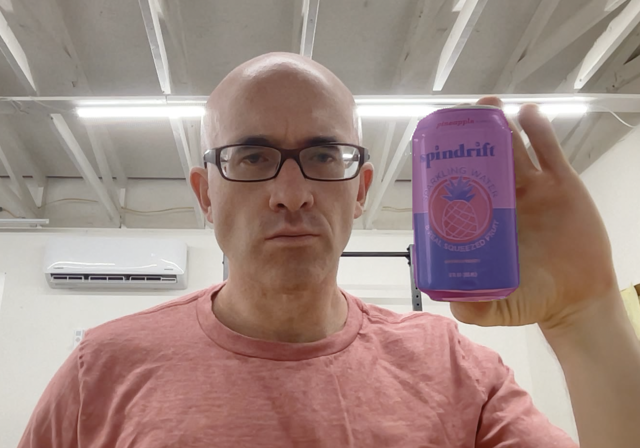

In [31]:
segmented_frame

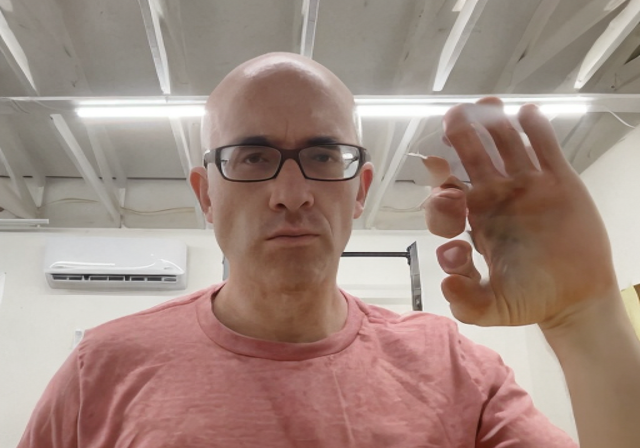

In [32]:
difused_frame